<a href="https://colab.research.google.com/github/tosittig/CASAIS/blob/main/W2_1_1_Sentiment_Analysis_Lin%2BLog_Regression_4colab_OUTPUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Sentiment Classification: Bag of Words

In this notebook, we consider *sentiment classification*, a standard task in natural language processing. Based on a review of a movie (or a restaurant, hotel, etc.), we want to predict whether the person liked the movie or not. As an example, we use a data set provided by the International Movie Database website www.imdb.com. The provided reviews are labeled with a binary rating whether they are positive (label 1) or negative (label 0).

## Set-up
First of all, we need to load the libraries that we will need for this task. We will use keras and tensorflow for this code example, so we load the relevant parts of this framework:

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Conv1D, Flatten, LSTM, Bidirectional
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant

In [ ]:
# initialize random number generators to ensure reproducibility:
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
# some more general libraries for evaluation purposes:
import matplotlib.pyplot as plt
import datetime

In [ ]:
# set some model parameters
VOCAB_SIZE = 1000
NUM_EPOCHS = 50 # set lower for fast results - set higher for good results
BUFFER_SIZE = 1000
BATCH_SIZE = 512
EMBED_DIM = 100

In [ ]:
# Configurations
tf.config.run_functions_eagerly(True)

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Loading the Data
The IMDb data set is available via the library `tensorflow_datasets`, which allows for easy access. The data is already split into a TRAIN and TEST set, each containing 25'000 labeled reviews. In order to obtain also a validation set, we further divide the TRAIN data set into 80% training and 20% validation data. The labels come directly with the respective texts:

In [ ]:
train_ds, val_ds, test_ds = tfds.load(
    name = "imdb_reviews",
    split = [ 'train[:80%]', 'train[80%:]', 'test' ],
    as_supervised = True)

The data sets are of a special data type which is optimized for handling large amounts of data and processing them on mulitple machines in parallel. We can get the number of samples as follows:

In [ ]:
train_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=20000>

First we look at some examples from the training data set:

In [ ]:
for example, label in train_ds.take(5):
  print("Input: ", example)
  print(10*".")
  print('Target labels: ', label)
  print(50*"-")

Input:  tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
..........
Target labels:  tf.Tensor(0, shape=(), dtype=int64)
--------------------------------------------------
Input:  tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, r

## Text Representation: Bag of Words
The text is raw text, without a lot of formatting, but it also includes some html tags. For a first try, we will start with a simple `TextVectorization` layer, that is similar to a bag of word. We will use a vocabulary size of 1000 words:

In [ ]:
encoderBoW = TextVectorization(output_mode = "count", max_tokens=VOCAB_SIZE)
encoderBoW.adapt(train_ds.map(lambda text, label: text))

The `.adapt()` method chooses the vocabulary of the layer based on the training data - this corresponds to a kind of training, but is done in an explicit step (essentially counting and sorting). The function `map(lambda text, label: text)` ensures that we only use the texts from the `train_ds` data set (and leave out the labels for the moment).

As we work with a `VOCAB_SIZE` of 1000, chances are high that some of the words will not be represented in the vocabulary. The `.adapt()` will return the most common 999 words, and all  other words are represented as `[UNK]` (for *unknown*). The tokens are sorted in descending order of frequency. Here are the first 20 tokens (i.e., the most frequent ones):

In [ ]:
vocab = np.array(encoderBoW.get_vocabulary())
vocab[:20]

array(['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but',
       'film'], dtype='<U14')

The first word in the vocabulary is `[UNK]`, the token for the unknown words. Afterwards, we have a number of token for very common words, the so-called **stop words**. The first one being 'the'. So, in the numerical vector that we get after coding, the first column corresponds to all unknown words (i.e. all words that do not appear in the vocabulary), and the second column corresponds to the word 'the'. Also some *domain-specific* words occur frequenty: `movie` and `film` indicate that the vocabulary was built on movie reviews.

We can now get an example encoding:

In [ ]:
encoderBoW("the")

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
print(example)

tf.Tensor(b'As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female libido. When men are around they want to be pursued, but when no "men" are around, they become the pursuers of a 14 year old boy. And the boy becomes a man really fast (we should all be so lucky at this age!). He then gets up the courage to pursue his true love.', shape=(), dtype=string)


In [ ]:
encoderBoW(example).numpy()

array([12.,  7.,  1.,  2.,  2.,  2.,  0.,  1.,  0.,  0.,  2.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  3.,  1.,
        2.,  1.,  0.,  0.,  1.,  2.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0

# A first Model: Linear Regression
We start with a first, very simple model. It corresponds to a multiple linear regression model, with the 1000-dimensional vector representation of the sentence as input (independent variables, predictors), and the rating (0 or 1) as output (dependent variable, target variable). While this could also be done with a classical regression, we start right away with a neural network, and will extend it gradually as we add more advanced concepts.

## Model Definition

In [ ]:
model_BoW_1L_lin = Sequential()
model_BoW_1L_lin.add(Input(shape=(1,), dtype='string'))
model_BoW_1L_lin.add(encoderBoW)
model_BoW_1L_lin.add(Dense(1))

In [ ]:
model_BoW_1L_lin.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_BoW_1L_lin.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 1000)              0         
 Vectorization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 1001 (3.91 KB)
Trainable params: 1001 (3.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training
Now, let's train the model. We do only a rather small number of epochs and include early stopping in order not to spend too much time on training.

In [ ]:
# initialize random number generators to ensure reproducibility:
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
history_BoW_1L_lin = model_BoW_1L_lin.fit(
    train_ds.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE),
    validation_data = val_ds.batch(BATCH_SIZE),
    epochs = NUM_EPOCHS, verbose = 1,
    callbacks = [ EarlyStopping(monitor='val_accuracy', patience=5,
                                verbose=False, restore_best_weights=True)])

Epoch 1/50
40/40 [==============================] - 3s 78ms/step - loss: 4.6581 - accuracy: 0.5020 - val_loss: 3.8365 - val_accuracy: 0.5314
Epoch 2/50
40/40 [==============================] - 4s 104ms/step - loss: 3.4991 - accuracy: 0.5525 - val_loss: 3.3266 - val_accuracy: 0.5738
Epoch 3/50
40/40 [==============================] - 3s 74ms/step - loss: 2.9309 - accuracy: 0.6018 - val_loss: 2.7515 - val_accuracy: 0.6218
Epoch 4/50
40/40 [==============================] - 3s 74ms/step - loss: 2.3820 - accuracy: 0.6460 - val_loss: 2.1575 - val_accuracy: 0.6672
Epoch 5/50
40/40 [==============================] - 4s 97ms/step - loss: 1.9962 - accuracy: 0.6816 - val_loss: 1.8596 - val_accuracy: 0.6990
Epoch 6/50
40/40 [==============================] - 3s 73ms/step - loss: 1.7454 - accuracy: 0.7133 - val_loss: 1.7033 - val_accuracy: 0.7184
Epoch 7/50
40/40 [==============================] - 3s 75ms/step - loss: 1.6056 - accuracy: 0.7289 - val_loss: 1.6931 - val_accuracy: 0.7266
Epoch 8/50
4

In [ ]:
model_BoW_1L_lin.save_weights('model_BoW_1L_lin')

## Evaluation
Our simple model already has an accuracy of some 84% on the validation data. Let's check the performance on the test data:

In [ ]:
results1 = model_BoW_1L_lin.evaluate(test_ds.batch(BATCH_SIZE), verbose=2)

for name, value in zip(model_BoW_1L_lin.metrics_names, results1):
    print("%s: %.3f" % (name, value))

49/49 - 3s - loss: 0.7703 - accuracy: 0.8382 - 3s/epoch - 57ms/step
loss: 0.770
accuracy: 0.838


We get similar performance on the novel test data.

## Interpretation
We want to try to interpret what the model has learned. To do so, we look at the weights that have been inferred.

In [ ]:
model_BoW_1L_lin_weights = model_BoW_1L_lin.layers[1].get_weights()[0]
model_BoW_1L_lin_weights

array([[-7.10924738e-04],
       [ 2.26891916e-02],
       [ 5.63038094e-03],
       [ 1.12612201e-02],
       [-2.62546558e-02],
       [-1.72222219e-02],
       [-1.41633991e-02],
       [-4.64105885e-03],
       [ 2.37019267e-02],
       [ 1.32149849e-02],
       [ 2.07915213e-02],
       [-1.83392931e-02],
       [ 2.44157505e-04],
       [-3.46913151e-02],
       [ 8.74994043e-03],
       [-8.00711662e-03],
       [-1.60832647e-02],
       [ 5.69930580e-03],
       [-1.95569452e-02],
       [ 6.91074086e-03],
       [-1.50114335e-02],
       [-8.60764831e-03],
       [ 3.57019380e-02],
       [-1.39683788e-03],
       [ 1.27037456e-02],
       [-1.56751685e-02],
       [ 9.46518872e-03],
       [ 2.48311162e-02],
       [ 5.26639353e-03],
       [ 2.26827208e-02],
       [ 1.20199202e-02],
       [-7.78723881e-03],
       [-9.04178433e-03],
       [ 8.61328468e-03],
       [-3.52988765e-02],
       [ 6.27341121e-03],
       [ 1.25573836e-02],
       [-1.62137731e-05],
       [ 7.8

`model1_BoW_weights[0]` contains the 1000 weights for the words in the dictionary, while `model1_BoW_weights[1]` is the bias or intercept of the linear regression. We look at the weights and search the indices with the largest values -- these will be the words that are the most positive:


In [ ]:
model_BoW_1L_lin_sortOrder = np.argsort(model_BoW_1L_lin_weights, axis=0)
vocab[model_BoW_1L_lin_sortOrder[-5:]]

array([['perfect'],
       ['superb'],
       ['amazing'],
       ['perfectly'],
       ['wonderful']], dtype='<U14')

That seems plausible! Similarly, we can look for the words that best indicate a bad review:

In [ ]:
vocab[model_BoW_1L_lin_sortOrder[:5]]

array([['poorly'],
       ['waste'],
       ['worst'],
       ['dull'],
       ['mess']], dtype='<U14')

## Evaluate Performance Development
Using the history (which we got from the fit() function), we can also check the evolution of the performance over the training epochs:

In [ ]:
history_BoW_1L_lin_dict = history_BoW_1L_lin.history

train_acc_BoW_1L_lin = history_BoW_1L_lin_dict['accuracy']
val_acc_BoW_1L_lin   = history_BoW_1L_lin_dict['val_accuracy']

train_loss_BoW_1L_lin = history_BoW_1L_lin_dict['loss']
val_loss_BoW_1L_lin   = history_BoW_1L_lin_dict['val_loss']

epochs_BoW_1L_lin    = range(1, len(train_acc_BoW_1L_lin) + 1)

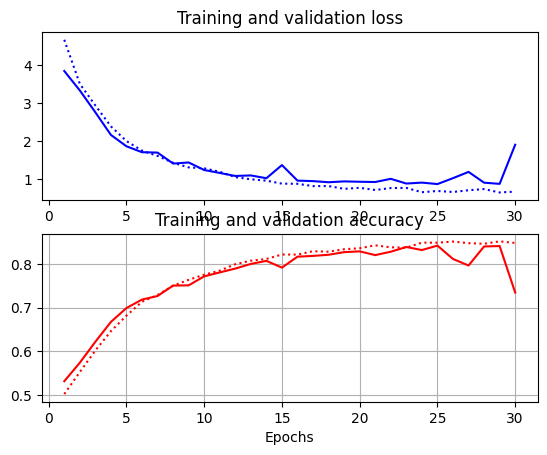

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(epochs_BoW_1L_lin, train_loss_BoW_1L_lin, 'b:', label='model_BoW_1L_lin, Training loss')
plt.plot(epochs_BoW_1L_lin, val_loss_BoW_1L_lin,   'b',  label='model_BoW_1L_lin, Validation loss')
plt.title('Training and validation loss')

plt.subplot(2, 1, 2)
plt.plot(epochs_BoW_1L_lin, train_acc_BoW_1L_lin, 'r:', label='model_BoW_1L_lin, Training acc')
plt.plot(epochs_BoW_1L_lin, val_acc_BoW_1L_lin,   'r',  label='model_BoW_1L_lin, Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.show()

# A slightly more advanced Model: Logistic Regression
As the output is binary, we might also see the task as binary classification, and logistic regression seems a natural choice. In the model above, we only need to change the activation function to `sigmoid`, and we already have a neural network doing logistic regression:

In [ ]:
# initialize random number generators to ensure reproducibility:
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
model_BoW_1L_sig = Sequential()
model_BoW_1L_sig.add(Input(shape=(1,), dtype='string'))
model_BoW_1L_sig.add(encoderBoW)
model_BoW_1L_sig.add(Dense(1, activation="sigmoid"))

In [ ]:
model_BoW_1L_sig.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history_BoW_1L_sig = model_BoW_1L_sig.fit(
    train_ds.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE),
    validation_data = val_ds.batch(BATCH_SIZE),
    epochs = NUM_EPOCHS, verbose = 1,
    callbacks = [ EarlyStopping(monitor='val_accuracy', patience=5,
                                verbose=False, restore_best_weights=True)])

# Evaluate Training Progress
history_BoW_1L_sig_dict = history_BoW_1L_sig.history

train_acc_BoW_1L_sig = history_BoW_1L_sig_dict['accuracy']
val_acc_BoW_1L_sig   = history_BoW_1L_sig_dict['val_accuracy']
epochs_BoW_1L_sig    = range(1, len(train_acc_BoW_1L_sig) + 1)

Epoch 1/50
40/40 [==============================] - 4s 80ms/step - loss: 0.8717 - accuracy: 0.5486 - val_loss: 0.6628 - val_accuracy: 0.6206
Epoch 2/50
40/40 [==============================] - 3s 75ms/step - loss: 0.5999 - accuracy: 0.6892 - val_loss: 0.5539 - val_accuracy: 0.7264
Epoch 3/50
40/40 [==============================] - 3s 72ms/step - loss: 0.5213 - accuracy: 0.7626 - val_loss: 0.5057 - val_accuracy: 0.7734
Epoch 4/50
40/40 [==============================] - 4s 102ms/step - loss: 0.4753 - accuracy: 0.7970 - val_loss: 0.4717 - val_accuracy: 0.7980
Epoch 5/50
40/40 [==============================] - 3s 76ms/step - loss: 0.4434 - accuracy: 0.8175 - val_loss: 0.4390 - val_accuracy: 0.8242
Epoch 6/50
40/40 [==============================] - 3s 72ms/step - loss: 0.4202 - accuracy: 0.8307 - val_loss: 0.4214 - val_accuracy: 0.8308
Epoch 7/50
40/40 [==============================] - 4s 98ms/step - loss: 0.4025 - accuracy: 0.8403 - val_loss: 0.4078 - val_accuracy: 0.8338
Epoch 8/50
4

In [ ]:
model_BoW_1L_sig.save_weights('model_BoW_1L_sig')

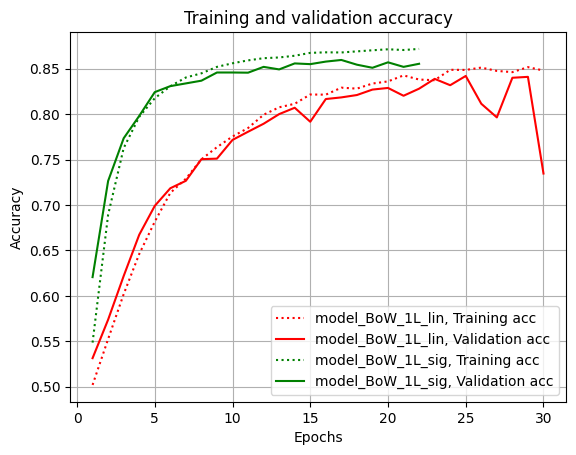

In [ ]:
plt.plot(epochs_BoW_1L_lin, train_acc_BoW_1L_lin, 'r:', label='model_BoW_1L_lin, Training acc')
plt.plot(epochs_BoW_1L_lin, val_acc_BoW_1L_lin,   'r',  label='model_BoW_1L_lin, Validation acc')
plt.plot(epochs_BoW_1L_sig, train_acc_BoW_1L_sig, 'g:', label='model_BoW_1L_sig, Training acc')
plt.plot(epochs_BoW_1L_sig, val_acc_BoW_1L_sig,   'g',  label='model_BoW_1L_sig, Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Word Embeddings
Until now, we have represented all words as an index (represented as an integer number or as one-hot encoding). This representation does not take similarities in the meaning of words into acocunt - two words are either the same or different.

Using a word embedding, we get a more detailed notion of word similarity. In a high-dimensional representation, the distance between two words will be defined by how similar they are (as infered from the training data). While word embeddings are usually used in connection with more complex models, we start here with a

In [ ]:
# initialize random number generators to ensure reproducibility:
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
model_embed_BoW_1L_sig = Sequential()
model_embed_BoW_1L_sig.add(Input(shape=(1,), dtype='string'))
model_embed_BoW_1L_sig.add(encoderBoW)
model_embed_BoW_1L_sig.add(Embedding(VOCAB_SIZE, EMBED_DIM))
model_embed_BoW_1L_sig.add(Flatten())
model_embed_BoW_1L_sig.add(Dense(1, activation="sigmoid"))

In [ ]:
model_embed_BoW_1L_sig.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_embed_BoW_1L_sig.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 1000)              0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 1000, 100)         100000    
                                                                 
 flatten (Flatten)           (None, 100000)            0         
                                                                 
 dense_3 (Dense)             (None, 1)                 100001    
                                                                 
Total params: 200001 (781.25 KB)
Trainable params: 200001 (781.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_embed_BoW_1L_sig = model_embed_BoW_1L_sig.fit(
    train_ds.shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE),
    validation_data = val_ds.batch(BATCH_SIZE),
    epochs = NUM_EPOCHS, verbose = 1,
    callbacks = [ EarlyStopping(monitor='val_accuracy', patience=5,
                                verbose=False, restore_best_weights=True)])

Epoch 1/50
40/40 [==============================] - 4s 105ms/step - loss: 0.7399 - accuracy: 0.5760 - val_loss: 0.5931 - val_accuracy: 0.6420
Epoch 2/50
40/40 [==============================] - 3s 86ms/step - loss: 0.5001 - accuracy: 0.7642 - val_loss: 0.4145 - val_accuracy: 0.8290
Epoch 3/50
40/40 [==============================] - 3s 83ms/step - loss: 0.3929 - accuracy: 0.8293 - val_loss: 0.3589 - val_accuracy: 0.8460
Epoch 4/50
40/40 [==============================] - 4s 106ms/step - loss: 0.3496 - accuracy: 0.8500 - val_loss: 0.3672 - val_accuracy: 0.8382
Epoch 5/50
40/40 [==============================] - 3s 84ms/step - loss: 0.3296 - accuracy: 0.8619 - val_loss: 0.3410 - val_accuracy: 0.8540
Epoch 6/50
40/40 [==============================] - 3s 84ms/step - loss: 0.3156 - accuracy: 0.8683 - val_loss: 0.3402 - val_accuracy: 0.8588
Epoch 7/50
40/40 [==============================] - 4s 101ms/step - loss: 0.3095 - accuracy: 0.8701 - val_loss: 0.3982 - val_accuracy: 0.8336
Epoch 8/50

In [ ]:
model_embed_BoW_1L_sig.save_weights('model_embed_BoW_1L_sig')

In [ ]:
# Evaluate Training Progress
history_embed_BoW_1L_sig_dict = history_embed_BoW_1L_sig.history

train_acc_embed_BoW_1L_sig_dict = history_embed_BoW_1L_sig_dict['accuracy']
val_acc_embed_BoW_1L_sig_dict   = history_embed_BoW_1L_sig_dict['val_accuracy']
epochs_embed_BoW_1L_sig_dict    = range(1, len(train_acc_embed_BoW_1L_sig_dict) + 1)

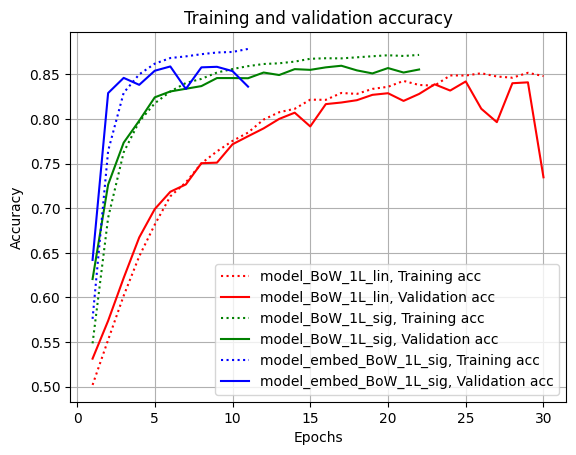

In [ ]:
plt.plot(epochs_BoW_1L_lin, train_acc_BoW_1L_lin, 'r:', label='model_BoW_1L_lin, Training acc')
plt.plot(epochs_BoW_1L_lin, val_acc_BoW_1L_lin,   'r',  label='model_BoW_1L_lin, Validation acc')

plt.plot(epochs_BoW_1L_sig, train_acc_BoW_1L_sig, 'g:', label='model_BoW_1L_sig, Training acc')
plt.plot(epochs_BoW_1L_sig, val_acc_BoW_1L_sig,   'g',  label='model_BoW_1L_sig, Validation acc')

plt.plot(epochs_embed_BoW_1L_sig_dict, train_acc_embed_BoW_1L_sig_dict, 'b:', label='model_embed_BoW_1L_sig, Training acc')
plt.plot(epochs_embed_BoW_1L_sig_dict, val_acc_embed_BoW_1L_sig_dict,   'b',  label='model_embed_BoW_1L_sig, Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The plot shows us several things:
* Embeddings do yield somewhat better results, but the improvement is not exciting - we might have expected more.
* Overfitting is becoming an issue: We reach the optimal performance on the validation data already after a few steps - afterwards, training performance continues to go up, but validation performance decreases.

Hence, we need some more advanced concepts - especially, as we still ignore the order of the words.